In [3]:
import torch
from torch import nn
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data import Dataset, DataLoader, RandomSampler, TensorDataset
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torchmetrics
import re
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

## Data Creation

In [4]:
blind_path = "../data/blind.fasta.txt"
cyto_path = "../data/cyto.fasta.txt"
mito_path = "../data/mito.fasta.txt"
nucleus_path = "../data/nucleus.fasta.txt"
other_path = "../data/other.fasta.txt"
secreted_path = "../data/secreted.fasta.txt"

In [5]:
def read_fasta(file):
    """
    This function takes an unstructured fasta file and outputs a dictionary of the sequences
    Input: - fasta file
    Output: - dict with keys (sequence header) and values (sequence)
    """
    sequences = {}
    with open(file, 'r') as f:
        header = ""
        sequence = ""
        for line in f:
            #in a fasta file the first character is a > sign
            if line[0] == ">":
                if header:
                    sequences[header] = sequence
                header = line[1:].strip()
                sequence = ""
            else:
                sequence += line.strip()
        sequences[header] = sequence
    return sequences

In [25]:
# This creates the dictionary of sequences for each location
blind_sequences = read_fasta(blind_path)
cyto_sequences = read_fasta(cyto_path)
mito_sequences = read_fasta(mito_path)
nucleus_sequences = read_fasta(nucleus_path)
other_sequences = read_fasta(other_path)
secreted_sequences = read_fasta(secreted_path)

df_cyto = pd.DataFrame.from_dict(cyto_sequences, orient='index', columns=['Sequences'])
df_cyto = df_cyto.reset_index().rename(columns={'index':'Label'})
df_cyto['Label'] = 'cyto'

df_mito = pd.DataFrame.from_dict(mito_sequences, orient='index', columns=['Sequences'])
df_mito = df_mito.reset_index().rename(columns={'index':'Label'})
df_mito['Label'] = 'mito'

df_nucleus = pd.DataFrame.from_dict(nucleus_sequences, orient='index', columns=['Sequences'])
df_nucleus = df_nucleus.reset_index().rename(columns={'index':'Label'})
df_nucleus['Label'] = 'nucleus'

df_other = pd.DataFrame.from_dict(other_sequences, orient='index', columns=['Sequences'])
df_other = df_other.reset_index().rename(columns={'index':'Label'})
df_other['Label'] = 'other'

df_secreted = pd.DataFrame.from_dict(secreted_sequences, orient='index', columns=['Sequences'])
df_secreted = df_secreted.reset_index().rename(columns={'index':'Label'})
df_secreted['Label'] = 'secreted'

df_blind = pd.DataFrame.from_dict(blind_sequences, orient='index', columns=['Sequences'])
df_blind = df_blind.reset_index().rename(columns={'index':'Label'})
df_blind['Label'] = 'blind'

df = pd.concat([df_cyto, df_mito, df_nucleus, df_other, df_secreted], axis=0).reset_index()
# Display the DataFrame
#df['encoded_cat'] = df['Label'].astype('category').cat.codes
#df.drop(columns={'index', 'Label'}, inplace=True)

#result = df.to_dict('records')

#one_hot = pd.get_dummies(df['Label'])
df = pd.concat([df, one_hot], axis=1)
df.drop(columns=['index', 'Label'], inplace=True)
df['Sequences'] = [re.sub(r"[UZOB]", "X", sample) for sample in df['Sequences']]

In [27]:
total_examples = len(df)

# sum up the labels to get number of examples per label
label_counts = df[['cyto','mito','nucleus','other','secreted']].sum()

# calculate overall average sequence length
overall_avg_len = df['Sequences'].str.len().mean()

# group DataFrame by labels and calculate average sequence length for each group
avg_len_by_label = df.groupby(['cyto','mito','nucleus','other','secreted'])['Sequences'].apply(lambda x: x.str.len().mean())

print("Total examples:", total_examples)
print("Label counts:", label_counts)
print("Overall average sequence length:", overall_avg_len)
print("Average sequence length by label:")
print(avg_len_by_label)

Total examples: 11224
Label counts: cyto        3004
mito        1299
nucleus     3314
other       2002
secreted    1605
dtype: int64
Overall average sequence length: 526.1143977191732
Average sequence length by label:
cyto  mito  nucleus  other  secreted
0     0     0        0      1           304.710280
                     1      0           430.595904
            1        0      0           624.464393
      1     0        0      0           375.569669
1     0     0        0      0           664.665446
Name: Sequences, dtype: float64


In [28]:
median_length = np.median(df['Sequences'].str.len())

In [29]:
median_length

407.0

In [30]:
import statistics

# Assuming `lengths` is a list of sequence lengths
mode_length = statistics.mode(lengths)
print("Mode sequence length:", mode_length)

NameError: name 'lengths' is not defined

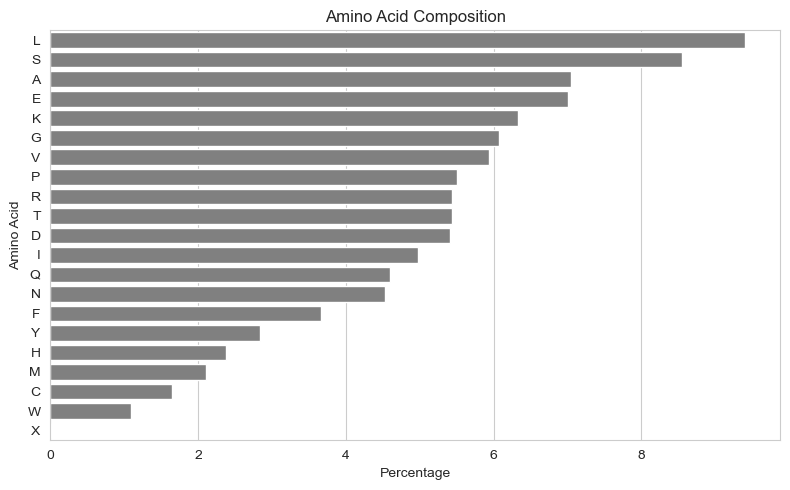

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns



# Create an empty dictionary to hold the counts of each amino acid
aa_counts = {}

# Loop over each protein sequence in the DataFrame and count the occurrence of each amino acid
for seq in df['Sequences']:
    for aa in seq:
        if aa in aa_counts:
            aa_counts[aa] += 1
        else:
            aa_counts[aa] = 1

# Calculate the total number of amino acids in all sequences
total_aa = sum(aa_counts.values())

# Calculate the percentage of each amino acid in the dataset
aa_percentages = {aa: count/total_aa*100 for aa, count in aa_counts.items()}

# Sort the amino acids by their percentage in the dataset
sorted_aa_percentages = sorted(aa_percentages.items(), key=lambda x: x[1], reverse=True)

labels = [aa for aa, pct in sorted_aa_percentages]
percentages = [pct for aa, pct in sorted_aa_percentages]

sns.set_style("whitegrid")
sns.set_palette("dark")
#sns.color_palette(["#BBC7D3", "#6C7A89", "#2C3E50", "#1F2D3D", "#152639"])
#sns.color_palette("Blues_r", n_colors=5)

plt.figure(figsize=(8,5))
ax = sns.barplot(x=percentages, y=labels, color='grey')
ax.set_xlabel('Percentage')
ax.set_ylabel('Amino Acid')
ax.set_title('Amino Acid Composition')
plt.tight_layout()

plt.savefig('amino_acid_composition.png', dpi=500, bbox_inches='tight')

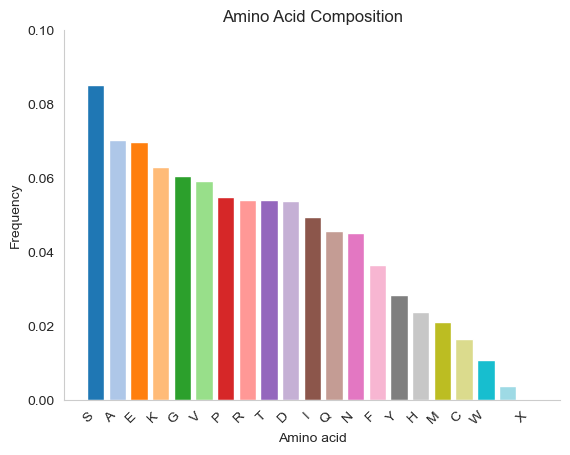

In [15]:
# Define color scheme
colors = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
          '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
          '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
          '#17becf', '#9edae5']



# Compute amino acid frequencies
aa_counts = df['Sequences'].str.split('').apply(pd.Series).stack().value_counts()
aa_freqs = aa_counts / aa_counts.sum()

# Define x-axis labels
x_labels = aa_freqs.index.values[1:]

# Create figure and axis objects
fig, ax = plt.subplots()
ax.grid(False)

# Plot bar chart
ax.bar(x_labels, aa_freqs[1:], color=colors)

# Set axis labels and title
ax.set_xlabel('Amino acid')
ax.set_ylabel('Frequency')
ax.set_title('Amino Acid Composition')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set y-axis range
ax.set_ylim([0, 0.1])

# Adjust x-axis tick labels
plt.xticks(rotation=45, ha='right')

# Save figure
#plt.savefig('amino_acid_composition.png', dpi=300, bbox_inches='tight')

# Show figure
plt.show()


In [31]:
df_blind.drop(columns=['Label', 'Label'], inplace=True)

In [34]:
target_list = ['cyto', 'mito', 'nucleus','other', 'secreted']

In [35]:
def train_test_split(df, validation_set = False):  
    
    #train test split of dataset 
    train_size = 0.8
    train_df=df.sample(frac=train_size,random_state=200)
    test_df=df.drop(train_df.index).reset_index(drop=True)
    train_df = train_df.reset_index(drop=True)
    
    if validation_set:
        #split the train further with a validation dataset
        train_size = 0.8
        train2_df = train_df.sample(frac=train_size, random_state=200)
        val_df = train_df.drop(train2_df.index).reset_index(drop=True)
        train2_df = train2_df.reset_index(drop=True)
    
        return train2_df, test_df, val_df
   
    return train_df, test_df

train_df, test_df, val_df = train_test_split(df, validation_set = True)

In [36]:
train_df[['cyto','mito','nucleus','other','secreted']]=train_df[['cyto','mito','nucleus','other','secreted']].astype('float')
test_df[['cyto','mito','nucleus','other','secreted']]=test_df[['cyto','mito','nucleus','other','secreted']].astype('float')
val_df[['cyto','mito','nucleus','other','secreted']]=val_df[['cyto','mito','nucleus','other','secreted']].astype('float')

In [37]:
train_df['Sequences'] = train_df['Sequences'].apply(lambda x: ' '.join(list(x)))
test_df['Sequences'] = test_df['Sequences'].apply(lambda x: ' '.join(list(x)))
val_df['Sequences'] = val_df['Sequences'].apply(lambda x: ' '.join(list(x)))


In [44]:
val_df

,Sequences,cyto,mito,nucleus,other,secreted
0,M N A F Q D F E L G A K L Y L Q C L L S L S S ...,0.0,0.0,1.0,0.0,0.0
1,M A E I I Q E R I E D R L P E L E Q L E R I G ...,0.0,0.0,1.0,0.0,0.0
2,M G L K E E F E E H A E K V N T L T E L P S N ...,1.0,0.0,0.0,0.0,0.0
3,M G A A R L L P N L T L C L Q L L I L C C Q T ...,0.0,0.0,0.0,0.0,1.0
4,M A D S P G C C S I W A R C L H C L Y S C H W ...,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
1791,M R S W P G L F W L L T L A L L A D G G R R E ...,0.0,0.0,0.0,0.0,1.0
1792,M K K S Y S G G T R T S S G R L R R L G D S S ...,1.0,0.0,0.0,0.0,0.0
1793,S K G K K A N K D V E L A R G,0.0,0.0,0.0,0.0,1.0
1794,M T T Q Q I V L Q G P G P W G F R L V G G K D ...,1.0,0.0,0.0,0.0,0.0


In [42]:
df_blind[['cyto','mito','nucleus','other','secreted']]=float(0.0)

In [43]:
df_blind['Sequences'] = df_blind['Sequences'].apply(lambda x: ' '.join(list(x)))

df_blind

,Sequences,cyto,mito,nucleus,other,secreted
0,M N E L I D S A L L R L ...,0.0,0.0,0.0,0.0,0.0
1,E E E S S T A K A F K I ...,0.0,0.0,0.0,0.0,0.0
2,M V G W K R N L Q T V I ...,0.0,0.0,0.0,0.0,0.0
3,M E R T R S K P V R N L ...,0.0,0.0,0.0,0.0,0.0
4,M S H H P S G L R A G F ...,0.0,0.0,0.0,0.0,0.0
5,M S L F S R A L M R F Q ...,0.0,0.0,0.0,0.0,0.0
6,M T W L K Q M W S S I L ...,0.0,0.0,0.0,0.0,0.0
7,M A T R E A C G Q F A A ...,0.0,0.0,0.0,0.0,0.0
8,M E T P A W P R V P R P ...,0.0,0.0,0.0,0.0,0.0
9,M Q N L K W V L M N L L ...,0.0,0.0,0.0,0.0,0.0


In [45]:
df_blind.to_pickle('blind_df.pkl')

In [129]:
train_df.to_pickle('train_df.pkl')

In [142]:
train_df.to_pickle('train_df.pkl')
test_df.to_pickle('test_df.pkl')
val_df.to_pickle('val_df.pkl')

In [144]:
df['Sequences'] = [" ".join("".join(sample.split())) for sample in df['Sequences']]

In [145]:
df

,Sequences,cyto,mito,nucleus,other,secreted
0,M G Q Q V G R V G E A P G L Q Q P Q P R G I R ...,1,0,0,0,0
1,M A L E P I D Y T T H S R E I D A E Y L K I V ...,1,0,0,0,0
2,M N Q I E P G V Q Y N Y V Y D E D E Y M I Q E ...,1,0,0,0,0
3,M S E E P T P V S G N D K Q L L N K A W E I T ...,1,0,0,0,0
4,M G D W M T V T D P G L S S E S K T I S Q Y T ...,1,0,0,0,0
...,...,...,...,...,...,...
11219,M I P N I T Q L K T A A L V M L F A G Q A L S ...,0,0,0,0,1
11220,M L R K L V T G A L A A A L L L S G Q S N A Q ...,0,0,0,0,1
11221,M I F H Q F Y S I L I L C L I F P N Q V V Q S ...,0,0,0,0,1
11222,M K F Q V V L S A L L A C S S A V V A S P I E ...,0,0,0,0,1


In [33]:
from torchmetrics.classification import F1Score
target = torch.tensor([0, 1, 2, 0, 1, 2])
preds = torch.tensor([0, 2, 1, 0, 0, 1])
f1 = F1Score(task="multiclass", num_classes=3)
f1(preds, target)

tensor(0.3333)